<a href="https://colab.research.google.com/github/amrmoohamed/RLinTrading/blob/main/Single_Instrument_gain_lose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Article**
https://levelup.gitconnected.com/using-tensortrade-for-making-a-simple-trading-algorithm-6fad4d9bc79c



#**installation**

In [ ]:
!#!cp -r /content/tensortrade /usr/local/lib/python3.7/dist-packages

#insatalling Tensortrade module
!pip install git+https://github.com/tensortrade-org/tensortrade.git
!pip install -r /content/tensortrade/requirements.txt
#installing some modules
!pip install ccxt
!pip install ray
!pip install symfit
!pip install tensorboardX

In [ ]:
!pip install yahoo_fin
!pip install yfinance

**Remember to restart runtime after installing!!**

#**Importing**

In [ ]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
import ray.rllib.agents.ppo as ppo
import tensortrade.env.default as default
from gym.spaces import Discrete
from ray import tune
from ray.tune.registry import register_env
from symfit import parameters, variables, sin, cos, Fit
from tensortrade.env.default.actions import TensorTradeActionScheme
from tensortrade.env.default.rewards import TensorTradeRewardScheme
from tensortrade.env.generic import Renderer
from tensortrade.feed.core import DataFeed, Stream
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.instruments import Instrument
from tensortrade.oms.orders import proportion_order
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio

In [ ]:
from pandas_datareader import data as pdr
from yahoo_fin import stock_info as si
from yahoo_fin.stock_info import get_data
from pandas import ExcelWriter
import yfinance as yf
import pandas as pd
import datetime
import time
yf.pdr_override()

#**Retreive Data**

In [ ]:
yeartoday = 365
years = 2
start_date = datetime.datetime.now() - datetime.timedelta(days= years*yeartoday)

end_date = datetime.date.today()

In [ ]:
gainers = si.get_day_gainers()
topgainersymbol = list(gainers[:1]['Symbol'])[0]

losers = si.get_day_losers()
toplosersymbol = list(losers[:1]['Symbol'])[0]

In [ ]:
print(topgainersymbol,toplosersymbol)

AMC MOR


In [ ]:
df = get_data(topgainersymbol,start_date,end_date,index_as_date = True, interval="1d")
df.to_csv(f'{topgainersymbol}.csv')

df = get_data(toplosersymbol,start_date,end_date,index_as_date = True, interval="1d")
df.to_csv(f'{toplosersymbol}.csv')

#**Top-gainer data preprocessing**

In [ ]:
data = pd.read_csv(f'{topgainersymbol}.csv', index_col=0)
data.head(2)

,open,high,low,close,adjclose,volume,ticker
2019-06-04,12.01,12.08,11.75,11.78,11.037498,2012500,AMC
2019-06-05,11.85,11.87,11.13,11.18,10.475316,3452700,AMC


In [ ]:
datasize = data.shape[0]
trainsize = 0.9
split = round(trainsize*datasize)
traindata = data.iloc[:split,:]
testdata = data.iloc[split:,:]

In [ ]:
print(data.shape,traindata.shape,testdata.shape)

(504, 7) (454, 7) (50, 7)


In [ ]:
Ctrainfeed = traindata['close'].to_numpy()
Ctestfeed = testdata['close'].to_numpy()

Otrainfeed = traindata['open'].to_numpy()
Otestfeed = testdata['open'].to_numpy()

Htrainfeed = traindata['high'].to_numpy()
Htestfeed = testdata['high'].to_numpy()

Ltrainfeed = traindata['low'].to_numpy()
Ltestfeed = testdata['low'].to_numpy()

Vtrainfeed = traindata['volume'].to_numpy()
Vtestfeed = testdata['volume'].to_numpy()

#**Top-loser data preprocessing**

In [ ]:
dataa = pd.read_csv(f'{toplosersymbol}.csv', index_col=0)
dataa.head(2)

,open,high,low,close,adjclose,volume,ticker
2019-06-04,23.41,23.410000,23.08,23.24,23.24,24800,MOR
2019-06-05,23.59,23.690001,23.17,23.25,23.25,20400,MOR


In [ ]:
datasize = dataa.shape[0]
trainsize = 0.9
split = round(trainsize*datasize)
traindataa = dataa.iloc[:split,:]
testdataa = dataa.iloc[split:,:]

In [ ]:
print(dataa.shape,traindataa.shape,testdataa.shape)

(504, 7) (454, 7) (50, 7)


In [ ]:
CCtrainfeed = traindataa['close'].to_numpy()
CCtestfeed = testdataa['close'].to_numpy()

OOtrainfeed = traindataa['open'].to_numpy()
OOtestfeed = testdataa['open'].to_numpy()

HHtrainfeed = traindataa['high'].to_numpy()
HHtestfeed = testdataa['high'].to_numpy()

LLtrainfeed = traindataa['low'].to_numpy()
LLtestfeed = testdataa['low'].to_numpy()

VVtrainfeed = traindataa['volume'].to_numpy()
VVtestfeed = testdataa['volume'].to_numpy()

#**Instruments**

In [ ]:
USD = Instrument("USD", 2, "U.S. Dollar")
G = Instrument(f"{topgainersymbol}", 2, "Gainer")
LL = Instrument(f"{toplosersymbol}", 2, "Loser")

#**Features functions**

In [ ]:
def rsi(price: Stream[float], period: float) -> Stream[float]:
  r = price.diff()
  upside = r.clamp_min(0).abs()
  downside = r.clamp_max(0).abs()
  rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
  return 100*(1 - (1 + rs) ** -1)

def macd(price: Stream[float], fast: float, slow: float, signal: float) -> Stream[float]:
  fm = price.ewm(span=fast, adjust=False).mean()
  sm = price.ewm(span=slow, adjust=False).mean()
  md = fm - sm
  signal = md - md.ewm(span=signal, adjust=False).mean()
  return signal

#**TensorTrade Classes**

In [ ]:
class BSH(TensorTradeActionScheme):

    registered_name = "bsh"

    def __init__(self, cash: 'Wallet', asset: 'Wallet'):
        super().__init__()
        self.cash = cash
        self.asset = asset

        self.listeners = []
        self.action = 0

    @property
    def action_space(self):
        return Discrete(2)

    def attach(self, listener):
        self.listeners += [listener]
        return self

    def get_orders(self, action: int, portfolio: 'Portfolio'):
        order = None

        if abs(action - self.action) > 0:
            src = self.cash if self.action == 0 else self.asset
            tgt = self.asset if self.action == 0 else self.cash
            order = proportion_order(portfolio, src, tgt, 1.0)
            self.action = action

        for listener in self.listeners:
            listener.on_action(action)

        return [order]

    def reset(self):
        super().reset()
        self.action = 0

In [ ]:
class PBR(TensorTradeRewardScheme):

    registered_name = "pbr"

    def __init__(self, price: 'Stream'):
        super().__init__()
        self.position = -1

        r = Stream.sensor(price, lambda p: p.value, dtype="float").diff()
        position = Stream.sensor(self, lambda rs: rs.position, dtype="float")

        reward = (r * position).fillna(0).rename("reward")

        self.feed = DataFeed([reward])
        self.feed.compile()

    def on_action(self, action: int):
        self.position = -1 if action == 0 else 1

    def get_reward(self, portfolio: 'Portfolio'):
        return self.feed.next()["reward"]

    def reset(self):
        self.position = -1
        self.feed.reset()

#**TopGainer**

In [ ]:
class PositionChangeChart(Renderer):

    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        p = list(history.price)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = p[i]
                else:
                    sell[i] = p[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(p)), p, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="^", color="green")
        axs[0].scatter(sell.index, sell.values, marker="^", color="red")
        axs[0].set_title("Trading Chart")
        axs[0].set_xlabel("Step")
        axs[0].set_ylabel("Price (USD/{})".format(topgainersymbol))

        performance = env.action_scheme.portfolio.performance
        performance = pd.DataFrame(performance).transpose()

        performance.net_worth.plot(ax=axs[1])
        axs[1].set_title("Net Worth")
        axs[1].set_xlabel("Step")
        axs[1].set_ylabel("Amount (USD)")

        plt.show()

In [ ]:
def create_env(config):

    #closeprice
    p = Stream.source(Ctrainfeed, dtype="float").rename("USD-{}".format(topgainersymbol))
    #open price
    O = Stream.source(Otrainfeed, dtype="float").rename("open")
    #volume
    V = Stream.source(Vtrainfeed, dtype="float").rename("volume")
    #high
    H = Stream.source(Htrainfeed, dtype="float").rename("high")
    #low
    L = Stream.source(Ltrainfeed, dtype="float").rename("low")
    
    stockexchange = Exchange('Nasdaq', service=execute_order)(
        p
    )

    cash = Wallet(stockexchange, 10000 * USD)
    asset = Wallet(stockexchange, 0 * G)

    portfolio = Portfolio(USD, [
        cash,
        asset
    ])


    feed = DataFeed([
        p,
        p.ewm(span=10).mean().rename("fast"),
        p.ewm(span=50).mean().rename("medium"),
        p.ewm(span=100).mean().rename("slow"),
        p.log().diff().fillna(0).rename("lr"),
        rsi(p, period=20).rename("rsi"),
        macd(p, fast=10, slow=50, signal=5).rename("macd"),    
        O,
        H,
        L,
        V
    ])

    reward_scheme = PBR(price=p)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(Ctrainfeed, dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.6
    )
    return environment


register_env("TradingEnv", create_env)

#**Train-Model**

In [ ]:
analysis = tune.run(
    "PPO",
    stop={
      "episode_reward_mean": 10
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": 25
        },
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": os.cpu_count() - 1,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },
    checkpoint_at_end=True
)

Trial name,status,loc
PPO_TradingEnv_a6577_00000,PENDING,


(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=1712) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=1712) Instructions for updating:
(pid=1712) non-resource variables are not supported in the long term
(pid=1712) 2021-06-03 03:56:21,023	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.
(pid=1712) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow_probability/python

Result for PPO_TradingEnv_a6577_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-06-03_03-56-41
  done: false
  episode_len_mean: 219.11764705882354
  episode_media: {}
  episode_reward_max: 9.070013523101812
  episode_reward_mean: -1.3647051278282585
  episode_reward_min: -8.270005226135261
  episodes_this_iter: 17
  episodes_total: 17
  experiment_id: b5fd380be05f415e87ec9c7bf0f28198
  hostname: b78a0b47223f
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.2
          cur_lr: 8.0e-06
          entropy: 0.6756782475858927
          entropy_coeff: 0.01
          kl: 0.018016928515862674
          policy_loss: -0.05989804497221485
          total_loss: 0.4254796290770173
          vf_explained_var: 0.0035233497619628906
          vf_loss: 0.9770621415227652
    num_agent_steps_sampled: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_since_restore: 1
  node_ip: 172.

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_a6577_00000,RUNNING,172.28.0.2:1712,1,15.1846,4000,-1.36471,9.07001,-8.27001,219.118


Result for PPO_TradingEnv_a6577_00000:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2021-06-03_03-56-56
  done: false
  episode_len_mean: 244.59375
  episode_media: {}
  episode_reward_max: 54.17000532150269
  episode_reward_mean: 2.6837506517767924
  episode_reward_min: -8.270005226135261
  episodes_this_iter: 15
  episodes_total: 32
  experiment_id: b5fd380be05f415e87ec9c7bf0f28198
  hostname: b78a0b47223f
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.2
          cur_lr: 8.0e-06
          entropy: 0.6083547249436378
          entropy_coeff: 0.01
          kl: 0.034071128466166556
          policy_loss: -0.07969042206241284
          total_loss: 0.40756660932675004
          vf_explained_var: 0.0072503723204135895
          vf_loss: 0.9730526991188526
    num_agent_steps_sampled: 8000
    num_steps_sampled: 8000
    num_steps_trained: 8000
  iterations_since_restore: 2
  node_ip: 172.28.0.2
  

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_a6577_00000,RUNNING,172.28.0.2:1712,2,29.9698,8000,2.68375,54.17,-8.27001,244.594


Result for PPO_TradingEnv_a6577_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2021-06-03_03-57-11
  done: false
  episode_len_mean: 283.609756097561
  episode_media: {}
  episode_reward_max: 54.17000532150269
  episode_reward_mean: 6.242195815574834
  episode_reward_min: -9.839997768402096
  episodes_this_iter: 9
  episodes_total: 41
  experiment_id: b5fd380be05f415e87ec9c7bf0f28198
  hostname: b78a0b47223f
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.30000000000000004
          cur_lr: 8.0e-06
          entropy: 0.5178290503099561
          entropy_coeff: 0.01
          kl: 0.023616845137439668
          policy_loss: -0.07662854000227526
          total_loss: 0.4018978360109031
          vf_explained_var: 0.02050645276904106
          vf_loss: 0.9532392229884863
    num_agent_steps_sampled: 12000
    num_steps_sampled: 12000
    num_steps_trained: 12000
  iterations_since_restore: 3
  

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_a6577_00000,RUNNING,172.28.0.2:1712,3,44.9104,12000,6.2422,54.17,-9.84,283.61


Result for PPO_TradingEnv_a6577_00000:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2021-06-03_03-57-26
  done: true
  episode_len_mean: 312.03921568627453
  episode_media: {}
  episode_reward_max: 60.969998359680176
  episode_reward_mean: 11.023529782014739
  episode_reward_min: -9.839997768402096
  episodes_this_iter: 10
  episodes_total: 51
  experiment_id: b5fd380be05f415e87ec9c7bf0f28198
  hostname: b78a0b47223f
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.45000000000000007
          cur_lr: 8.0e-06
          entropy: 0.44765788316726685
          entropy_coeff: 0.01
          kl: 0.017543388297781348
          policy_loss: -0.07691253241500817
          total_loss: 0.37608433747664094
          vf_explained_var: 0.05123722553253174
          vf_loss: 0.8991578631103039
    num_agent_steps_sampled: 16000
    num_steps_sampled: 16000
    num_steps_trained: 16000
  iterations_since_restore

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_a6577_00000,RUNNING,172.28.0.2:1712,4,59.6976,16000,11.0235,60.97,-9.84,312.039


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_a6577_00000,TERMINATED,,4,59.6976,16000,11.0235,60.97,-9.84,312.039


(pid=1712) 2021-06-03 03:57:26,604	ERROR worker.py:382 -- SystemExit was raised from the worker
(pid=1712) Traceback (most recent call last):
(pid=1712)   File "python/ray/_raylet.pyx", line 495, in ray._raylet.execute_task
(pid=1712)   File "python/ray/_raylet.pyx", line 505, in ray._raylet.execute_task
(pid=1712)   File "python/ray/_raylet.pyx", line 449, in ray._raylet.execute_task.function_executor
(pid=1712)   File "/usr/local/lib/python3.7/dist-packages/ray/_private/function_manager.py", line 556, in actor_method_executor
(pid=1712)     return method(__ray_actor, *args, **kwargs)
(pid=1712)   File "/usr/local/lib/python3.7/dist-packages/ray/actor.py", line 1001, in __ray_terminate__
(pid=1712)     ray.actor.exit_actor()
(pid=1712)   File "/usr/local/lib/python3.7/dist-packages/ray/actor.py", line 1077, in exit_actor
(pid=1712)     raise exit
(pid=1712) SystemExit: 0
(pid=1712) 
(pid=1712) During handling of the above exception, another exception occurred:
(pid=1712) 
(pid=1712) T

In [ ]:
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial(metric="episode_reward_mean", mode="max"),
    metric="episode_reward_mean"
)
checkpoint_path = checkpoints[0][0]

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": {
            "window_size": 25
        },
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    }
)
agent.restore(checkpoint_path)

2021-06-03 03:57:40,199	INFO trainer.py:696 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=1779) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=1779) Instructions for updating:
(pid=1779) non-resource variables are not supported in the long term
(pid=1779) 2021-06-03 03:57:43,079	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RL

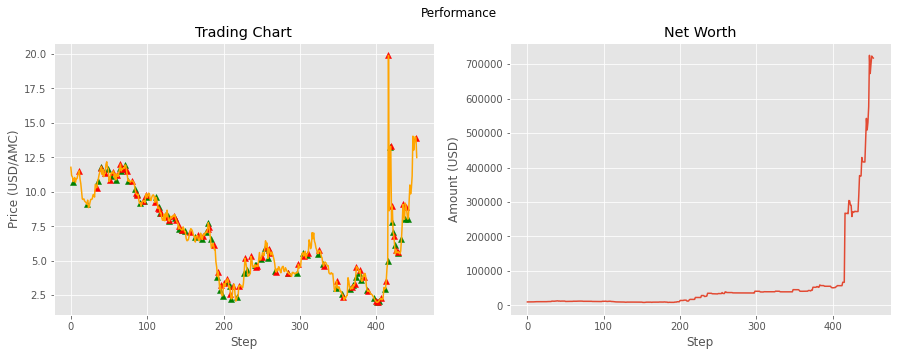

In [ ]:
env = create_env({
    "window_size": 25
})

episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()

#**Evaluate**

In [ ]:
def create_eval_env(config: dict):
    
    #close price
    p = Stream.source(Ctestfeed, dtype="float").rename("USD-{}".format(topgainersymbol))
    #open price
    O = Stream.source(Otestfeed, dtype="float").rename("open")
    #volume
    V = Stream.source(Vtestfeed, dtype="float").rename("volume")
    #high
    H = Stream.source(Htestfeed, dtype="float").rename("high")
    #low
    L = Stream.source(Ltestfeed, dtype="float").rename("low")
    stockexchange = Exchange("Nasdaq", service=execute_order)(
        p
    )

    cash = Wallet(stockexchange, 10000 * USD)
    asset = Wallet(stockexchange, 0 * G)

    portfolio = Portfolio(USD, [
        cash,
        asset
    ])

    feed = DataFeed([
        p,
        p.ewm(span=10).mean().rename("fast"),
        p.ewm(span=50).mean().rename("medium"),
        p.ewm(span=100).mean().rename("slow"),
        p.log().diff().fillna(0).rename("lr"),
        rsi(p, period=20).rename("rsi"),
        macd(p, fast=10, slow=50, signal=5).rename("macd"),
        O,
        H,
        L,
        V
    ])

    reward_scheme = PBR(price=p)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(Ctestfeed, dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.6
    )
    return environment

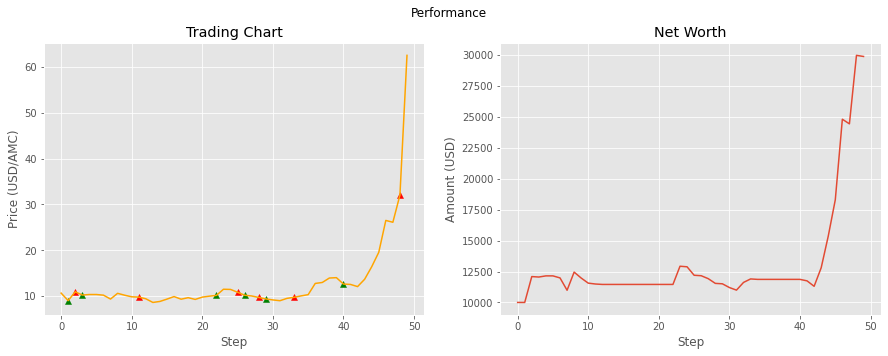

In [ ]:
env = create_eval_env({
    "window_size": 25
})

episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()

#**Top loser**

In [ ]:
class PositionChangeChart(Renderer):

    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        history = pd.DataFrame(env.observer.renderer_history)

        actions = list(history.action)
        p = list(history.price)

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = p[i]
                else:
                    sell[i] = p[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(p)), p, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="^", color="green")
        axs[0].scatter(sell.index, sell.values, marker="^", color="red")
        axs[0].set_title("Trading Chart")
        axs[0].set_xlabel("Step")
        axs[0].set_ylabel("Price (USD/{})".format(toplosersymbol))

        performance = env.action_scheme.portfolio.performance
        performance = pd.DataFrame(performance).transpose()

        performance.net_worth.plot(ax=axs[1])
        axs[1].set_title("Net Worth")
        axs[1].set_xlabel("Step")
        axs[1].set_ylabel("Amount (USD)")

        plt.show()

In [ ]:
def create_env(config):

    #closeprice
    p = Stream.source(CCtrainfeed, dtype="float").rename("USD-{}".format(toplosersymbol))
    #open price
    O = Stream.source(OOtrainfeed, dtype="float").rename("open")
    #volume
    V = Stream.source(VVtrainfeed, dtype="float").rename("volume")
    #high
    H = Stream.source(HHtrainfeed, dtype="float").rename("high")
    #low
    L = Stream.source(LLtrainfeed, dtype="float").rename("low")
    
    stockexchange = Exchange('Nasdaq', service=execute_order)(
        p
    )

    cash = Wallet(stockexchange, 10000 * USD)
    asset = Wallet(stockexchange, 0 * LL)

    portfolio = Portfolio(USD, [
        cash,
        asset
    ])


    feed = DataFeed([
        p,
        p.ewm(span=10).mean().rename("fast"),
        p.ewm(span=50).mean().rename("medium"),
        p.ewm(span=100).mean().rename("slow"),
        p.log().diff().fillna(0).rename("lr"),
        rsi(p, period=20).rename("rsi"),
        macd(p, fast=10, slow=50, signal=5).rename("macd"),    
        O,
        H,
        L,
        V
    ])

    reward_scheme = PBR(price=p)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(CCtrainfeed, dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.6
    )
    return environment


register_env("TradingEnv", create_env)

#**Train-Model**

In [ ]:
analysis = tune.run(
    "PPO",
    stop={
      "episode_reward_mean": 10
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": 25
        },
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": os.cpu_count() - 1,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },
    checkpoint_at_end=True
)

2021-06-03 04:35:04,925	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8265


Trial name,status,loc
PPO_TradingEnv_128fe_00000,RUNNING,


(pid=2374) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=2374) Instructions for updating:
(pid=2374) non-resource variables are not supported in the long term
(pid=2374) 2021-06-03 04:35:09,626	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RLlib performance. To install lz4, run `pip install lz4`.
(pid=2374) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/variadic_reduce.py:115: calling function (from tensorflow.python.eager.def_function) with experimental_compile is deprecated and will be removed in a future version.
(pid=2374) Instructions for updating:
(pid=2374) experimental_compile is deprecated, use jit_compile instead
(pid=2374) 2021-06-03 04:35:10,569	INFO trainer.py:696 -- Cur

Result for PPO_TradingEnv_128fe_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-06-03_04-35-28
  done: false
  episode_len_mean: 432.6666666666667
  episode_media: {}
  episode_reward_max: 23.32999420166025
  episode_reward_mean: -0.24778111775714726
  episode_reward_min: -27.01000595092773
  episodes_this_iter: 9
  episodes_total: 9
  experiment_id: 262d928414fb4cdcb7245571023171e5
  hostname: b78a0b47223f
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.2
          cur_lr: 8.0e-06
          entropy: 0.6735356580466032
          entropy_coeff: 0.01
          kl: 0.019828237709589303
          policy_loss: -0.05629975534975529
          total_loss: 0.42948038689792156
          vf_explained_var: 0.004589097574353218
          vf_loss: 0.9770997129380703
    num_agent_steps_sampled: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000
  iterations_since_restore: 1
  node_ip: 172.28

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_128fe_00000,RUNNING,172.28.0.2:2374,1,14.8967,4000,-0.247781,23.33,-27.01,432.667


(pid=2373) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=2373)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_128fe_00000:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2021-06-03_04-35-43
  done: false
  episode_len_mean: 442.8333333333333
  episode_media: {}
  episode_reward_max: 39.090011596679574
  episode_reward_mean: 9.01388867696126
  episode_reward_min: -27.01000595092773
  episodes_this_iter: 9
  episodes_total: 18
  experiment_id: 262d928414fb4cdcb7245571023171e5
  hostname: b78a0b47223f
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.2
          cur_lr: 8.0e-06
          entropy: 0.5928338691592216
          entropy_coeff: 0.01
          kl: 0.04025201383046806
          policy_loss: -0.09477395069552585
          total_loss: 0.3938384857028723
          vf_explained_var: 0.009536871686577797
          vf_loss: 0.972980760037899
    num_agent_steps_sampled: 8000
    num_steps_sampled: 8000
    num_steps_trained: 8000
  iterations_since_restore: 2
  node_ip: 172.28.0.2


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_128fe_00000,RUNNING,172.28.0.2:2374,2,29.7858,8000,9.01389,39.09,-27.01,442.833


(pid=2373) /usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
(pid=2373)   return self.op(self.inputs[0].value, self.inputs[1].value)


Result for PPO_TradingEnv_128fe_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2021-06-03_04-35-58
  done: true
  episode_len_mean: 445.96153846153845
  episode_media: {}
  episode_reward_max: 71.68999862670893
  episode_reward_mean: 25.162686568040105
  episode_reward_min: -27.01000595092773
  episodes_this_iter: 8
  episodes_total: 26
  experiment_id: 262d928414fb4cdcb7245571023171e5
  hostname: b78a0b47223f
  info:
    learner:
      default_policy:
        learner_stats:
          allreduce_latency: 0.0
          cur_kl_coeff: 0.30000000000000004
          cur_lr: 8.0e-06
          entropy: 0.5059659034013748
          entropy_coeff: 0.01
          kl: 0.024227891175542027
          policy_loss: -0.07395277035539038
          total_loss: 0.39402193343266845
          vf_explained_var: 0.025399746373295784
          vf_loss: 0.9315320011228323
    num_agent_steps_sampled: 12000
    num_steps_sampled: 12000
    num_steps_trained: 12000
  iterations_since_restore: 

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_128fe_00000,RUNNING,172.28.0.2:2374,3,44.3459,12000,25.1627,71.69,-27.01,445.962


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_TradingEnv_128fe_00000,TERMINATED,,3,44.3459,12000,25.1627,71.69,-27.01,445.962


2021-06-03 04:35:59,048	INFO tune.py:549 -- Total run time: 52.18 seconds (51.56 seconds for the tuning loop).


In [ ]:
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial(metric="episode_reward_mean", mode="max"),
    metric="episode_reward_mean"
)
checkpoint_path = checkpoints[0][0]

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": {
            "window_size": 25
        },
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": 1,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    }
)
agent.restore(checkpoint_path)

2021-06-03 04:36:02,647	INFO trainer.py:696 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(raylet) /usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   "update your install command.", FutureWarning)
(pid=2456) WARNING:tensorflow:From /usr/local/lib/python3.7/dist-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=2456) Instructions for updating:
(pid=2456) non-resource variables are not supported in the long term
(pid=2456) 2021-06-03 04:36:05,477	WARNING compression.py:16 -- lz4 not available, disabling sample compression. This will significantly impact RL

/usr/local/lib/python3.7/dist-packages/tensortrade/feed/core/operators.py:171: RuntimeWarning: divide by zero encountered in true_divide
  return self.op(self.inputs[0].value, self.inputs[1].value)


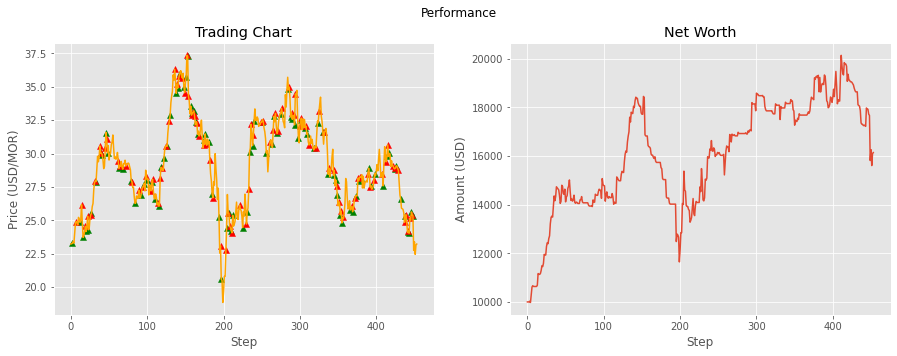

In [ ]:
env = create_env({
    "window_size": 25
})

episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()

#**Evaluate**

In [ ]:
def create_eval_env(config: dict):
    
    #close price
    p = Stream.source(CCtestfeed, dtype="float").rename("USD-{}".format(toplosersymbol))
    #open price
    O = Stream.source(OOtestfeed, dtype="float").rename("open")
    #volume
    V = Stream.source(VVtestfeed, dtype="float").rename("volume")
    #high
    H = Stream.source(HHtestfeed, dtype="float").rename("high")
    #low
    L = Stream.source(LLtestfeed, dtype="float").rename("low")
    stockexchange = Exchange("Nasdaq", service=execute_order)(
        p
    )

    cash = Wallet(stockexchange, 10000 * USD)
    asset = Wallet(stockexchange, 0 * LL)

    portfolio = Portfolio(USD, [
        cash,
        asset
    ])

    feed = DataFeed([
        p,
        p.ewm(span=10).mean().rename("fast"),
        p.ewm(span=50).mean().rename("medium"),
        p.ewm(span=100).mean().rename("slow"),
        p.log().diff().fillna(0).rename("lr"),
        rsi(p, period=20).rename("rsi"),
        macd(p, fast=10, slow=50, signal=5).rename("macd"),
        O,
        H,
        L,
        V
    ])

    reward_scheme = PBR(price=p)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(CCtestfeed, dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.6
    )
    return environment

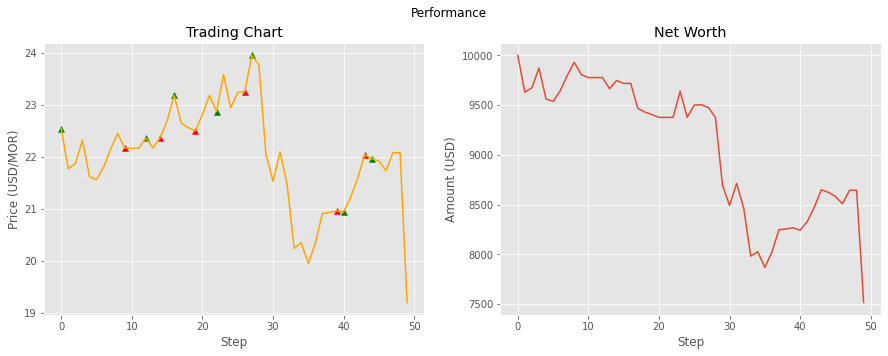

In [ ]:
env = create_eval_env({
    "window_size": 25
})

episode_reward = 0
done = False
obs = env.reset()

while not done:
    action = agent.compute_action(obs)
    obs, reward, done, info = env.step(action)
    episode_reward += reward

env.render()